In [83]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt
from scipy.stats import zscore
import seaborn as sns
import math
import warnings
import pickle

# Suprimir todos los warnings
warnings.filterwarnings('ignore')

In [113]:
data = pd.read_csv("../data/modeling/crimen.txt", sep="\t")
print(data.shape)
data.head()

(36, 16)


,M,So,Ed,Po1,Po2,LF,M.F,Pop,NW,U1,U2,Wealth,Ineq,Prob,Time,Crime
0,15.1,1,9.1,5.8,5.6,0.510,95.0,33,30.1,0.108,4.1,3940,26.1,0.084602,26.2011,791
1,14.3,0,11.3,10.3,9.5,0.583,101.2,13,10.2,0.096,3.6,5570,19.4,0.029599,25.2999,1635
2,14.2,1,8.9,4.5,4.4,0.533,96.9,18,21.9,0.094,3.3,3180,25.0,0.083401,24.3006,578
3,13.6,0,12.1,14.9,14.1,0.577,99.4,157,8.0,0.102,3.9,6730,16.7,0.015801,29.9012,1969
4,14.1,0,12.1,10.9,10.1,0.591,98.5,18,3.0,0.091,2.0,5780,17.4,0.041399,21.2998,1234


In [114]:
data.describe()

,M,So,Ed,Po1,Po2,LF,M.F,Pop,NW,U1,U2,Wealth,Ineq,Prob,Time,Crime
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,13.686111,0.305556,10.605556,8.897222,8.402778,0.559500,98.027778,39.277778,10.313889,0.095472,3.436111,5324.444444,19.111111,0.046544,27.097339,946.611111
std,1.148951,0.467177,1.066086,3.134735,2.920224,0.037405,2.972888,40.885632,10.270767,0.017912,0.835003,997.982091,3.936698,0.024425,6.898653,417.935489
min,11.900000,0.000000,8.700000,4.500000,4.400000,0.497000,93.400000,3.000000,0.400000,0.070000,2.000000,2880.000000,12.600000,0.006900,17.600000,342.000000
25%,12.775000,0.000000,9.900000,6.450000,6.175000,0.532500,96.400000,12.250000,2.550000,0.080750,2.800000,4695.000000,16.575000,0.031076,21.774775,677.500000
50%,13.500000,0.000000,10.850000,8.150000,7.650000,0.550000,97.250000,26.500000,7.800000,0.093000,3.450000,5485.000000,17.500000,0.041648,25.400200,852.500000
75%,14.300000,1.000000,11.375000,11.000000,10.200000,0.583750,98.600000,46.250000,11.425000,0.102250,3.925000,6177.500000,21.800000,0.057175,30.151250,1216.000000
max,16.600000,1.000000,12.100000,16.600000,15.700000,0.641000,107.100000,168.000000,42.300000,0.142000,5.800000,6890.000000,27.600000,0.119804,44.000400,1993.000000


In [115]:
data.isna().sum()

,0
M,0
So,0
Ed,0
Po1,0
Po2,0
LF,0
M.F,0
Pop,0
NW,0
U1,0


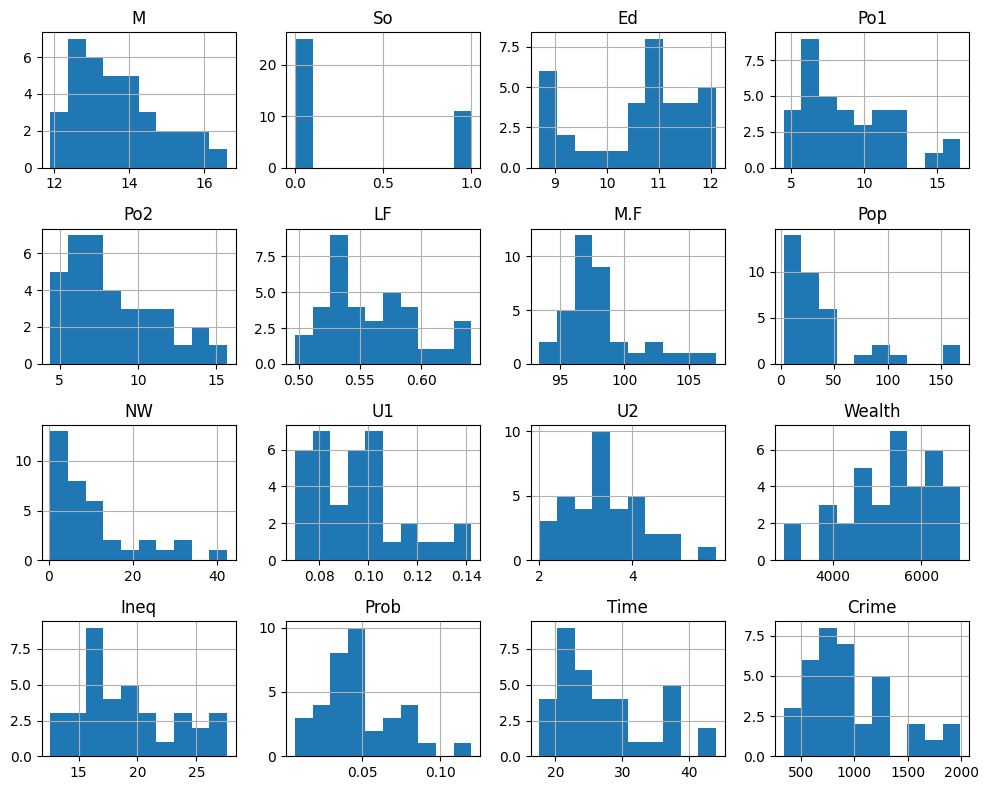

In [116]:
data.hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

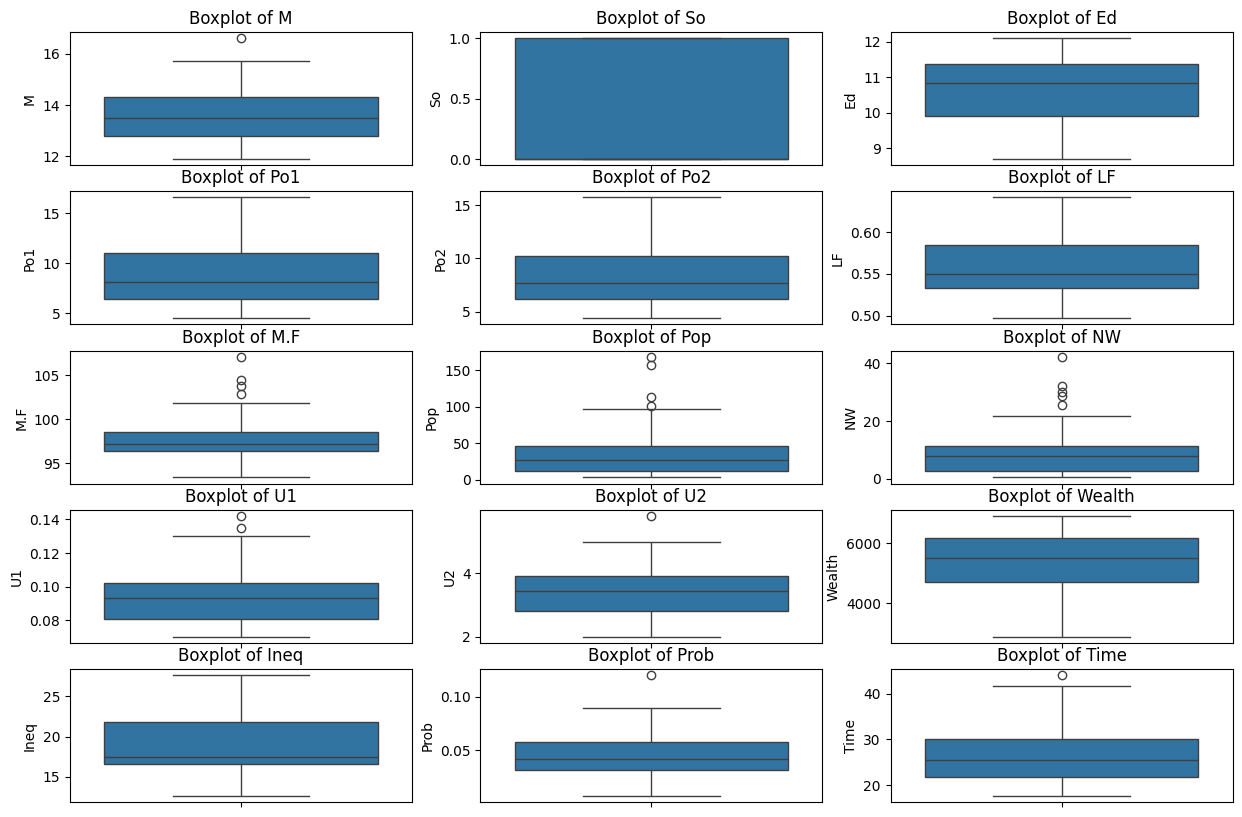

In [117]:
plt.figure(figsize=(15, 10))

for i, var in enumerate(data.columns[:-1], 1):
    plt.subplot(math.ceil(len(data.columns[:-1]) / 3), 3, i)  # Ajusta el número de filas y columnas según el número de variables
    sns.boxplot(y=var, data=data)
    plt.title(f'Boxplot of {var}')

In [118]:
z_scores = data[['Pop', 'M.F']].apply(zscore)

# Detectar outliers
outliers = data[(z_scores > 3) | (z_scores < -3)].any(axis=1)
print("Porcentaje de valores atípicos: ", round(len(data[outliers])/len(data)*100, 2),"%")
data[outliers]

Porcentaje de valores atípicos:  5.56 %


,M,So,Ed,Po1,Po2,LF,M.F,Pop,NW,U1,U2,Wealth,Ineq,Prob,Time,Crime
25,13.1,0,12.1,16.0,14.3,0.631,107.1,3,7.7,0.102,4.1,6740,15.2,0.041698,22.1005,1993
28,11.9,0,10.7,16.6,15.7,0.521,93.8,168,8.9,0.092,3.6,6370,15.4,0.023400,36.7009,1043


In [119]:
data = data[~outliers]
data

,M,So,Ed,Po1,Po2,LF,M.F,Pop,NW,U1,U2,Wealth,Ineq,Prob,Time,Crime
0,15.1,1,9.1,5.8,5.6,0.510,95.0,33,30.1,0.108,4.1,3940,26.1,0.084602,26.2011,791
1,14.3,0,11.3,10.3,9.5,0.583,101.2,13,10.2,0.096,3.6,5570,19.4,0.029599,25.2999,1635
2,14.2,1,8.9,4.5,4.4,0.533,96.9,18,21.9,0.094,3.3,3180,25.0,0.083401,24.3006,578
3,13.6,0,12.1,14.9,14.1,0.577,99.4,157,8.0,0.102,3.9,6730,16.7,0.015801,29.9012,1969
4,14.1,0,12.1,10.9,10.1,0.591,98.5,18,3.0,0.091,2.0,5780,17.4,0.041399,21.2998,1234
5,12.1,0,11.0,11.8,11.5,0.547,96.4,25,4.4,0.084,2.9,6890,12.6,0.034201,20.9995,682
6,12.7,1,11.1,8.2,7.9,0.519,98.2,4,13.9,0.097,3.8,6200,16.8,0.042100,20.6993,963
7,13.1,1,10.9,11.5,10.9,0.542,96.9,50,17.9,0.079,3.5,4720,20.6,0.040099,24.5988,1555
8,15.7,1,9.0,6.5,6.2,0.553,95.5,39,28.6,0.081,2.8,4210,23.9,0.071697,29.4001,856
9,14.0,0,11.8,7.1,6.8,0.632,102.9,7,1.5,0.100,2.4,5260,17.4,0.044498,19.5994,705


In [120]:
scaler = RobustScaler()
variables_estandarizar = ['M', 'Ed', 'Po1', 'Po2', 'LF', 'M.F', 'Pop', 'NW', 'U1', 'U2', 'Wealth', 'Ineq', 'Prob', 'Time']
data[variables_estandarizar] = scaler.fit_transform(data[variables_estandarizar])

In [121]:
X = data.drop(columns=['Crime'])
y = data['Crime']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [122]:
# Creación del modelo de regresión lineal
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred = model_lr.predict(X_test)

# Evaluación del modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Error Cuadrático Medio (MSE) con regresión lineal: {round(mse,3)}')
print(f'Error Absoluto Medio (MAE) con regresión lineal: {round(mae,3)}')
print(f'Coeficiente de Determinación (R²) con estandarización: {round(r2,3)}')

Error Cuadrático Medio (MSE) con regresión lineal: 207524.891
Error Absoluto Medio (MAE) con regresión lineal: 371.52
Coeficiente de Determinación (R²) con estandarización: -1.491


In [123]:
# Obtener los coeficientes y el intercepto del modelo
coefficients_lr = model_lr.coef_
intercept_lr = model_lr.intercept_

# Mostrar los coeficientes y el intercepto
print("Intercepto:", intercept_lr)
print("Coeficientes:", coefficients_lr)

# Crear un DataFrame para mostrar los coeficientes con sus respectivas características
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients_lr
})

print(coef_df)

Intercepto: 905.5183609499438
Coeficientes: [ 128.88736307 -120.81615576  239.27203176 1208.95569896 -704.87490022
 -170.96530988  145.4453788    28.59938789  222.35856051 -152.61569168
   -7.62098345  139.6614386   432.28748915 -182.92617414   30.50595071]
   Feature  Coefficient
0        M   128.887363
1       So  -120.816156
2       Ed   239.272032
3      Po1  1208.955699
4      Po2  -704.874900
5       LF  -170.965310
6      M.F   145.445379
7      Pop    28.599388
8       NW   222.358561
9       U1  -152.615692
10      U2    -7.620983
11  Wealth   139.661439
12    Ineq   432.287489
13    Prob  -182.926174
14    Time    30.505951


In [124]:
coef_df.to_excel("../data/modeling/Coeficientes_reg_lineal.xlsx", index = False)

In [125]:
# Modelo de Elastic Net
elastic_net_model = ElasticNet(random_state=42)

# Definir la rejilla de hiperparámetros
param_distributions = {
    'alpha': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'l1_ratio': [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4.5, 5]
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=elastic_net_model,param_distributions=param_distributions,n_iter=10000,scoring='r2',random_state=42)

# Entrenar el modelo usando RandomizedSearchCV
random_search.fit(X_train, y_train)

# Obtener los mejores parámetros
best_params = random_search.best_params_
print("Mejores parámetros: ", best_params)

best_elastic_net_model = ElasticNet(alpha=best_params['alpha'], l1_ratio=best_params['l1_ratio'], random_state=42)
best_elastic_net_model.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred_best_elastic_net = best_elastic_net_model.predict(X_test)

#elastic_net_model.fit(X_train, y_train)
#y_pred_elastic_net = elastic_net_model.predict(X_test)

mse_elastic_net = mean_squared_error(y_test, y_pred_best_elastic_net)
mae_elastic_net = mean_absolute_error(y_test, y_pred_best_elastic_net)
r2_elastic_net = r2_score(y_test, y_pred_best_elastic_net)

print(f'Error Cuadrático Medio (MSE) con Elastic Net: {round(mse_elastic_net,3)}')
print(f'Error Abosluto Medio (MAE) con Elastic Net: {round(mae_elastic_net,3)}')
print(f'Coeficiente de Determinación (R²) con Elastic Net: {round(r2_elastic_net,3)}')

Mejores parámetros:  {'l1_ratio': 1, 'alpha': 10}
Error Cuadrático Medio (MSE) con Elastic Net: 119200.577
Error Abosluto Medio (MAE) con Elastic Net: 268.73
Coeficiente de Determinación (R²) con Elastic Net: -0.431


In [126]:
# Obtener los coeficientes y el intercepto del modelo
coefficients_best_elastic_net = best_elastic_net_model.coef_
intercept_best_elastic_net = best_elastic_net_model.intercept_

# Mostrar los coeficientes y el intercepto
print("Intercepto:", intercept_best_elastic_net)
print("Coeficientes:", coefficients_best_elastic_net)

# Crear un DataFrame para mostrar los coeficientes con sus respectivas características
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients_best_elastic_net
})

print(coef_df)

Intercepto: 809.8584773211184
Coeficientes: [  99.92906151    0.           71.62665329  493.64598887    0.
    0.           98.62064424   23.74639064  165.08548629  -64.92596305
    0.            0.          232.87344576 -162.80417492   18.5360089 ]
   Feature  Coefficient
0        M    99.929062
1       So     0.000000
2       Ed    71.626653
3      Po1   493.645989
4      Po2     0.000000
5       LF     0.000000
6      M.F    98.620644
7      Pop    23.746391
8       NW   165.085486
9       U1   -64.925963
10      U2     0.000000
11  Wealth     0.000000
12    Ineq   232.873446
13    Prob  -162.804175
14    Time    18.536009


In [127]:
coef_df.to_excel("../data/modeling/Coeficientes_elastic_net.xlsx", index = False)

In [137]:
# Modelo de Random Forest
rf_model = RandomForestRegressor(n_estimators=500, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Error Cuadrático Medio (MSE) con Random Forest: {round(mse_rf,3)}')
print(f'Error Abosluto Medio (MAE) con Random Forest: {round(mae_rf,3)}')
print(f'Coeficiente de Determinación (R²) con Random Forest: {round(r2_rf,3)}')

Error Cuadrático Medio (MSE) con Random Forest: 31917.942
Error Abosluto Medio (MAE) con Random Forest: 140.658
Coeficiente de Determinación (R²) con Random Forest: 0.617


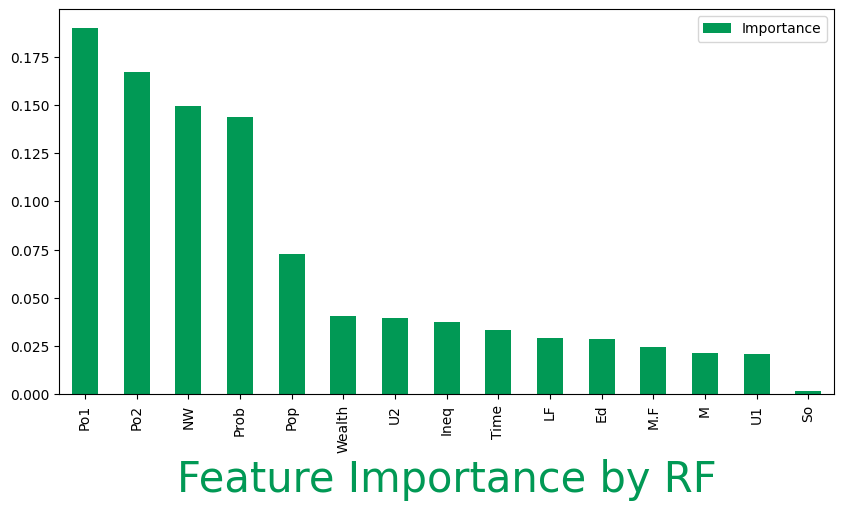

In [138]:
#Feature Importance
feature_importance_rf = pd.DataFrame({'Importance' : rf_model.feature_importances_}, index = X_train.columns)
feature_importance_rf.sort_values(by = 'Importance', ascending = False, axis = 0).plot(kind = 'bar', color = '#019955', figsize = (10, 5))
plt.xlabel("Feature Importance by RF", color = "#019955", fontdict= {"fontsize" : 30});

In [139]:
feature_importance_rf.to_excel("../data/modeling/Importancia_variables_RF.xlsx", index = False)

In [140]:
# Guardar el modelo usando pickle
with open('../models/random_forest_regressor.pkl', 'wb') as file:
    pickle.dump(rf_model, file)